In [1]:
from scipy import io
import numpy as np

import matplotlib.pyplot as plt

# plt.style.use("seaborn")

from sklearn.decomposition import PCA

from sklearn.linear_model import Ridge, LinearRegression

from sklearn.preprocessing import PolynomialFeatures
from tqdm import tqdm

In [2]:
data = io.loadmat("../burgers_data/burgers_data_R10.mat")

In [3]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF

## Importing the data and creating the B-splines

In [4]:
def get_data(ntrain, ntest):
    sub_x = 2 ** 6
    sub_y = 2 ** 6

    # Data is of the shape (number of samples = 2048, grid size = 2^13)
    data = io.loadmat("../burgers_data/burgers_data_R10.mat")
    x_data = data["a"][:, ::sub_x].astype(np.float64)
    y_data = data["u"][:, ::sub_y].astype(np.float64)
    x_branch_train = x_data[:ntrain, :]
    y_train = y_data[:ntrain, :]
    x_branch_test = x_data[-ntest:, :]
    y_test = y_data[-ntest:, :]
    
        
    s = 2 ** 13 // sub_y  # total grid size divided by the subsampling rate
    grid = np.linspace(0, 1, num=2 ** 13)[::sub_y, None]
    
    return x_branch_train, y_train, x_branch_test, y_test, grid


    x_train = (x_branch_train, grid)
    x_test = (x_branch_test, grid)
    return x_train, y_train, x_test, y_test

In [5]:
x, y, x_test, y_test, grid = get_data(2048-200, 200)

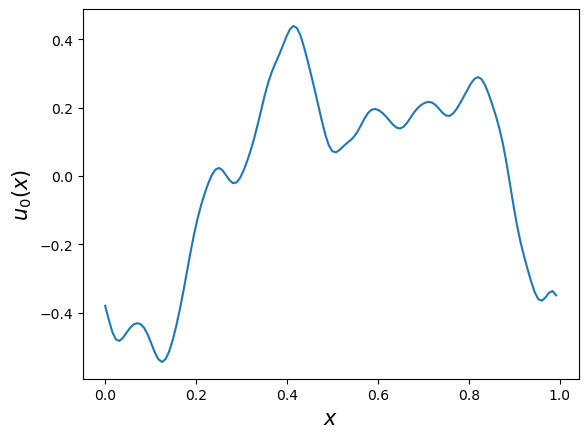

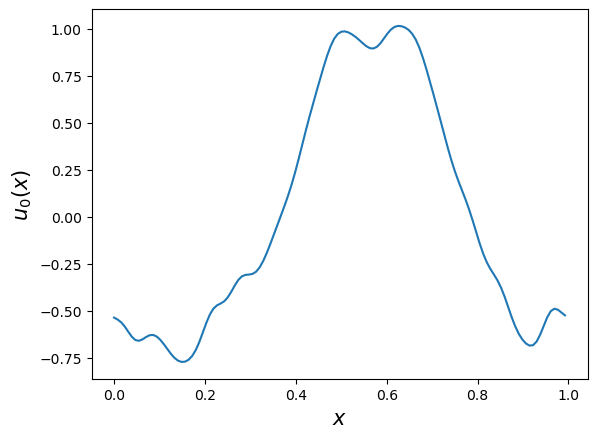

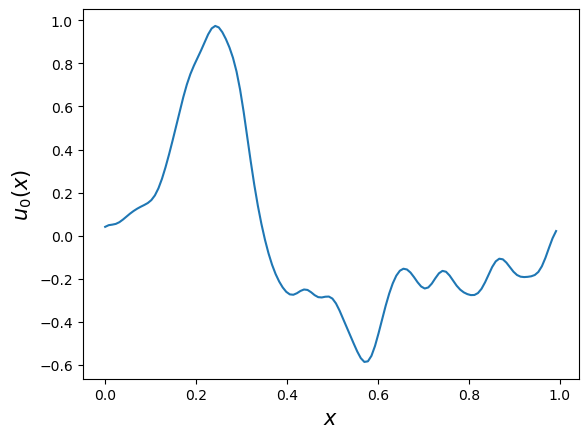

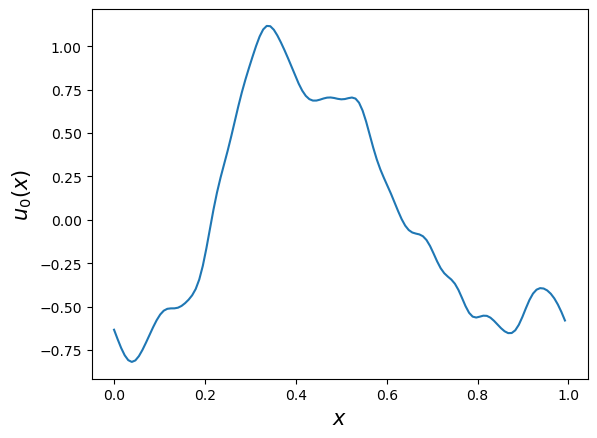

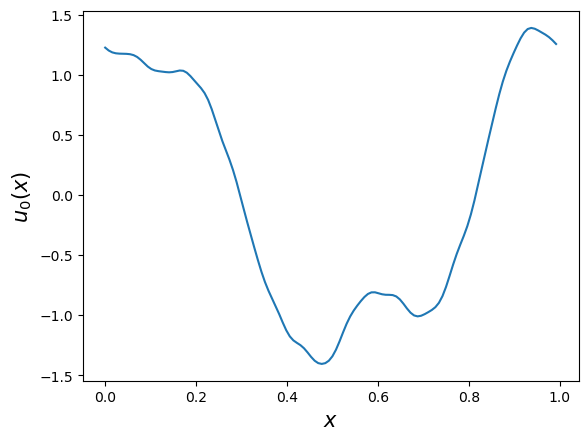

In [6]:
for i in range(5):
    x_train = x[i*169: i*169 + 1000]
    #print(x.shape, x[0,0])
    
    idx = 2

    plt.figure()
    plt.plot(grid, x_train[idx])
    plt.xlabel(r'$x$', size= 15)
    plt.ylabel(r'$u_0(x)$', size= 15)
    

## Fitting the GP: PCA

In [7]:
kernel = Matern(nu = 2.5)
#kernel = RBF()
gp = GaussianProcessRegressor(kernel, alpha = 1e-10) 

In [8]:
def train_test(x_train, x_test, y_train, y_test, n_pca):
    # Compute the PCA decoposition
    pca = PCA(n_components=n_pca)
    x_train_pca = pca.fit_transform(x_train)
    x_test_pca = pca.transform(x_test)
    
    #print(x_train_pca.shape)
    #print(x_test_pca.shape)
    kernel = Matern(nu = 2.5)
    gp = GaussianProcessRegressor(kernel, alpha = 1e-10,  normalize_y = True, random_state= 1172023) 
    
    print(x_train_pca.shape, y_train.shape)

    gp.fit(x_train_pca, y_train)
    pred= gp.predict(x_test_pca)
    #pred_train = gp.predict(x_train)

    #e = compute_error_dataset(y_test, pred, knots, k)

    return pred, gp

In [9]:
n_pca = 10
error = []
for i in tqdm(range(5)):
    x_train = x[i*169: i*169 + 1000]
    y_train = y[i*169: i*169 + 1000]
    #print(x_train.shape)
    pred, GP = train_test(x_train, x_test, y_train, y_test, n_pca)
    e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))
    error.append(e)

print(np.mean(error)) # average training error over 5 different training sets of 1000 samples

  0%|          | 0/5 [00:00<?, ?it/s]

(1000, 10) (1000, 128)


 20%|██        | 1/5 [00:17<01:10, 17.51s/it]

(1000, 10) (1000, 128)


 20%|██        | 1/5 [00:30<02:00, 30.18s/it]


KeyboardInterrupt: 

In [ ]:
pca_modes = np.arange(5, 20)

pca_error = []
for n_pca in tqdm(pca_modes):
    error = []
    for i in range(5):
        x_train = x[i*169: i*169 + 1000]
        y_train = y[i*169: i*169 + 1000]
        #print(x_train.shape)
        pred, GP = train_test(x_train, x_test, y_train, y_test, n_pca)
        e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))
        error.append(e)
    pca_error.append(np.mean(error))

#print(np.mean(error))

 73%|███████▎  | 11/15 [14:34<05:17, 79.48s/it]


KeyboardInterrupt: 

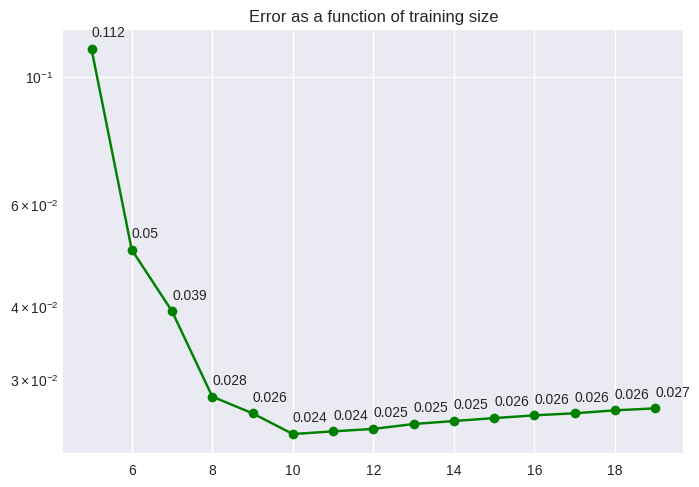

In [ ]:
plt.figure()
plt.plot(pca_modes,pca_error, '-go')
plt.yscale('log')
plt.title("Error as a function of training size")

for s, d in zip(pca_error, pca_modes):
    plt.annotate(np.round(s, 3), xy = (d ,s + s/20 ))
    
    
plt.show()

In [ ]:
np.min(pca_error)

0.024114421639920697

In [ ]:
def train_test(x_train, x_test, y_train, y_test, n_pca):
    # Compute the PCA decoposition
    pca = PCA(n_components=n_pca)
    x_train_pca = pca.fit_transform(x_train)
    x_test_pca = pca.transform(x_test)
    
    #print(x_train_pca.shape)
    #print(x_test_pca.shape)
    kernel = Matern(nu = 2.5)
    gp = GaussianProcessRegressor(kernel, alpha = 1e-10,  normalize_y = True, random_state= 1172023) 
    
    gp.fit(x_train_pca, y_train)
    pred= gp.predict(x_test_pca)
    pred_train = gp.predict(x_train_pca)

    #e = compute_error_dataset(y_test, pred, knots, k)

    return pred, pred_train, gp

In [ ]:
n_pca = 10

In [ ]:
i = 1
x_train = x[i*169: i*169 + 1000]
y_train = y[i*169: i*169 + 1000]

pred, pred_train, GP = train_test(x_train, x_test, y_train, y_test, n_pca)

In [ ]:
pred.shape, pred_train.shape

((200, 128), (1000, 128))

In [ ]:
e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))
e

0.024024327704946957

In [62]:
def train_test(x_train, x_test, y_train, y_test, n_pca, model):
    pred = []
    for i in tqdm(range(y_train.shape[-1])):
        model.fit(x_train[:, i].reshape(-1, 1), y_train[:, i]) # I changed this line to do a 1-1 mapping rather than 10-1
        pred.append(model.predict(x_test[:, i].reshape(-1, 1)))
        print(model.kernel_)
    #pred_train = gp.predict(x_train)

    #e = compute_error_dataset(y_test, pred, knots, k)

    return np.stack(pred).T, model

In [63]:
x_pca = PCA(n_components=100)
y_pca = PCA(n_components=100)
x_train_pca = x_pca.fit_transform(x_train)
y_train_pca = y_pca.fit_transform(y_train)

x_test_pca = x_pca.transform(x_test)
# x_test_pca_true = x_pca.fit_transform(x_test)

y_test_pca = y_pca.transform(y_test)
# y_test_pca_true = y_pca.fit_transform(y_test)


# for PC in range(10):
#     plt.figure()
#     plt.plot(x_test_pca[:, i], x_test_pca_true[:, i], marker = 'o', linestyle = 'None')
#     plt.xlabel(f'predicted PC {PC+1}')
#     plt.ylabel(f'true PC {PC+1}')
#     plt.show()




x_train_pca.shape, x_test_pca.shape

((1000, 100), (200, 100))

In [64]:
kernel = Matern(nu = 2.5)
gp = GaussianProcessRegressor(kernel, alpha = 1e-10,  normalize_y = False, random_state = 1172023) 
y_pca_pred, model = train_test(x_train_pca, x_test_pca, y_train_pca, y_test_pca, n_pca, gp)


  1%|          | 1/100 [00:03<06:26,  3.91s/it]

Matern(length_scale=7.28e-05, nu=2.5)


  2%|▏         | 2/100 [00:05<04:00,  2.46s/it]/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
  3%|▎         | 3/100 [00:05<02:16,  1.40s/it]

Matern(length_scale=1.77e-05, nu=2.5)
Matern(length_scale=1e-05, nu=2.5)


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
  4%|▍         | 4/100 [00:05<01:27,  1.10it/s]/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
  5%|▌         | 5/100 [00:05<01:00,  1.57it/s]

Matern(length_scale=1e-05, nu=2.5)
Matern(length_scale=1e-05, nu=2.5)


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
  6%|▌         | 6/100 [00:05<00:44,  2.09it/s]

Matern(length_scale=1e-05, nu=2.5)


  7%|▋         | 7/100 [00:07<01:14,  1.25it/s]/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
  8%|▊         | 8/100 [00:07<00:55,  1.67it/s]

Matern(length_scale=1.13e-05, nu=2.5)
Matern(length_scale=1e-05, nu=2.5)


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
  9%|▉         | 9/100 [00:07<00:42,  2.16it/s]/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
 10%|█         | 10/100 [00:07<00:33,  2.72it/s]

Matern(length_scale=1e-05, nu=2.5)
Matern(length_scale=1e-05, nu=2.5)


 11%|█         | 11/100 [00:09<01:03,  1.40it/s]

Matern(length_scale=3.05e-05, nu=2.5)


 12%|█▏        | 12/100 [00:11<01:27,  1.01it/s]

Matern(length_scale=2.17e-05, nu=2.5)


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
 13%|█▎        | 13/100 [00:11<01:07,  1.29it/s]/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
 14%|█▍        | 14/100 [00:11<00:50,  1.69it/s]

Matern(length_scale=1e-05, nu=2.5)
Matern(length_scale=1e-05, nu=2.5)


 15%|█▌        | 15/100 [00:13<01:23,  1.02it/s]

Matern(length_scale=7.54e-05, nu=2.5)


 16%|█▌        | 16/100 [00:15<01:46,  1.27s/it]/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
 17%|█▋        | 17/100 [00:15<01:17,  1.07it/s]

Matern(length_scale=4.32e-05, nu=2.5)
Matern(length_scale=1e-05, nu=2.5)


 18%|█▊        | 18/100 [00:16<01:26,  1.06s/it]/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
 19%|█▉        | 19/100 [00:16<01:04,  1.26it/s]

Matern(length_scale=2.5e-05, nu=2.5)
Matern(length_scale=1e-05, nu=2.5)


 20%|██        | 20/100 [00:18<01:26,  1.09s/it]

Matern(length_scale=3.24e-05, nu=2.5)


 21%|██        | 21/100 [00:20<01:37,  1.23s/it]

Matern(length_scale=4.59e-05, nu=2.5)


 22%|██▏       | 22/100 [00:22<01:55,  1.49s/it]

Matern(length_scale=5.18e-05, nu=2.5)


 23%|██▎       | 23/100 [00:24<02:01,  1.57s/it]

Matern(length_scale=4.51e-05, nu=2.5)


 24%|██▍       | 24/100 [00:26<02:23,  1.89s/it]

Matern(length_scale=4.24e-05, nu=2.5)


 25%|██▌       | 25/100 [00:35<05:00,  4.01s/it]

Matern(length_scale=0.000115, nu=2.5)


 26%|██▌       | 26/100 [00:37<04:04,  3.30s/it]

Matern(length_scale=2.82e-05, nu=2.5)


 27%|██▋       | 27/100 [00:39<03:41,  3.03s/it]

Matern(length_scale=3.76e-05, nu=2.5)


 28%|██▊       | 28/100 [00:41<03:05,  2.58s/it]

Matern(length_scale=2.88e-05, nu=2.5)


 29%|██▉       | 29/100 [00:44<03:15,  2.76s/it]

Matern(length_scale=5.54e-05, nu=2.5)


 30%|███       | 30/100 [00:46<02:59,  2.57s/it]

Matern(length_scale=4.85e-05, nu=2.5)


 31%|███       | 31/100 [00:48<02:45,  2.40s/it]

Matern(length_scale=3.95e-05, nu=2.5)


 32%|███▏      | 32/100 [00:50<02:32,  2.24s/it]

Matern(length_scale=2.8e-05, nu=2.5)


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 33%|███▎      | 33/100 [01:12<09:04,  8.13s/it]

Matern(length_scale=8.98e-05, nu=2.5)


 34%|███▍      | 34/100 [01:13<06:31,  5.94s/it]/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
 35%|███▌      | 35/100 [01:13<04:33,  4.21s/it]

Matern(length_scale=1.07e-05, nu=2.5)
Matern(length_scale=1e-05, nu=2.5)


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 36%|███▌      | 36/100 [01:27<07:30,  7.04s/it]

Matern(length_scale=9.18e-05, nu=2.5)


 37%|███▋      | 37/100 [01:34<07:36,  7.24s/it]

Matern(length_scale=5e-05, nu=2.5)


 38%|███▊      | 38/100 [01:37<06:04,  5.87s/it]

Matern(length_scale=3.22e-05, nu=2.5)


 39%|███▉      | 39/100 [01:43<06:11,  6.08s/it]

Matern(length_scale=4.27e-05, nu=2.5)


 42%|████▏     | 42/100 [01:59<04:35,  4.74s/it]

Matern(length_scale=7.84e-05, nu=2.5)
Matern(length_scale=1, nu=2.5)
Matern(length_scale=1, nu=2.5)


 44%|████▍     | 44/100 [01:59<02:41,  2.89s/it]

Matern(length_scale=1, nu=2.5)
Matern(length_scale=1, nu=2.5)
Matern(length_scale=1, nu=2.5)


 48%|████▊     | 48/100 [01:59<01:05,  1.27s/it]

Matern(length_scale=1, nu=2.5)
Matern(length_scale=1, nu=2.5)
Matern(length_scale=1, nu=2.5)


 51%|█████     | 51/100 [01:59<00:34,  1.43it/s]

Matern(length_scale=1, nu=2.5)
Matern(length_scale=1, nu=2.5)
Matern(length_scale=1, nu=2.5)


 53%|█████▎    | 53/100 [02:00<00:23,  2.03it/s]

Matern(length_scale=1, nu=2.5)
Matern(length_scale=1, nu=2.5)
Matern(length_scale=1, nu=2.5)


 57%|█████▋    | 57/100 [02:00<00:11,  3.58it/s]

Matern(length_scale=1, nu=2.5)
Matern(length_scale=1, nu=2.5)
Matern(length_scale=1, nu=2.5)


 59%|█████▉    | 59/100 [02:00<00:08,  4.56it/s]

Matern(length_scale=1, nu=2.5)
Matern(length_scale=1, nu=2.5)
Matern(length_scale=1, nu=2.5)


 61%|██████    | 61/100 [02:00<00:07,  5.53it/s]

Matern(length_scale=1, nu=2.5)
Matern(length_scale=1, nu=2.5)


 64%|██████▍   | 64/100 [02:01<00:05,  6.26it/s]

Matern(length_scale=1, nu=2.5)
Matern(length_scale=1, nu=2.5)


 67%|██████▋   | 67/100 [02:01<00:04,  7.93it/s]

Matern(length_scale=1, nu=2.5)
Matern(length_scale=1, nu=2.5)
Matern(length_scale=1, nu=2.5)


 69%|██████▉   | 69/100 [02:01<00:03,  8.64it/s]

Matern(length_scale=1, nu=2.5)
Matern(length_scale=1, nu=2.5)
Matern(length_scale=1, nu=2.5)


 73%|███████▎  | 73/100 [02:02<00:02,  9.55it/s]

Matern(length_scale=1, nu=2.5)
Matern(length_scale=1, nu=2.5)
Matern(length_scale=1, nu=2.5)


 75%|███████▌  | 75/100 [02:02<00:03,  8.25it/s]

Matern(length_scale=1, nu=2.5)
Matern(length_scale=1, nu=2.5)
Matern(length_scale=1, nu=2.5)


 79%|███████▉  | 79/100 [02:02<00:02,  9.36it/s]

Matern(length_scale=1, nu=2.5)
Matern(length_scale=1, nu=2.5)
Matern(length_scale=1, nu=2.5)


 82%|████████▏ | 82/100 [02:03<00:01,  9.71it/s]

Matern(length_scale=1, nu=2.5)
Matern(length_scale=1, nu=2.5)
Matern(length_scale=1, nu=2.5)


 84%|████████▍ | 84/100 [02:03<00:01,  9.47it/s]

Matern(length_scale=1, nu=2.5)
Matern(length_scale=1, nu=2.5)


 86%|████████▌ | 86/100 [02:03<00:01,  9.35it/s]

Matern(length_scale=1, nu=2.5)
Matern(length_scale=1, nu=2.5)


 88%|████████▊ | 88/100 [02:03<00:01,  8.88it/s]

Matern(length_scale=1, nu=2.5)
Matern(length_scale=1, nu=2.5)


 90%|█████████ | 90/100 [02:03<00:01,  8.90it/s]

Matern(length_scale=1, nu=2.5)
Matern(length_scale=1, nu=2.5)


 92%|█████████▏| 92/100 [02:04<00:00,  9.09it/s]

Matern(length_scale=1, nu=2.5)
Matern(length_scale=1, nu=2.5)
Matern(length_scale=1, nu=2.5)


 96%|█████████▌| 96/100 [02:04<00:00,  9.97it/s]

Matern(length_scale=1, nu=2.5)
Matern(length_scale=1, nu=2.5)
Matern(length_scale=1, nu=2.5)


 99%|█████████▉| 99/100 [02:04<00:00, 10.05it/s]

Matern(length_scale=1, nu=2.5)
Matern(length_scale=1, nu=2.5)
Matern(length_scale=1, nu=2.5)


100%|██████████| 100/100 [02:04<00:00,  1.25s/it]

Matern(length_scale=1, nu=2.5)


median relative L2: 1.005688091757749
mean relative L2: 1.0111405003221132


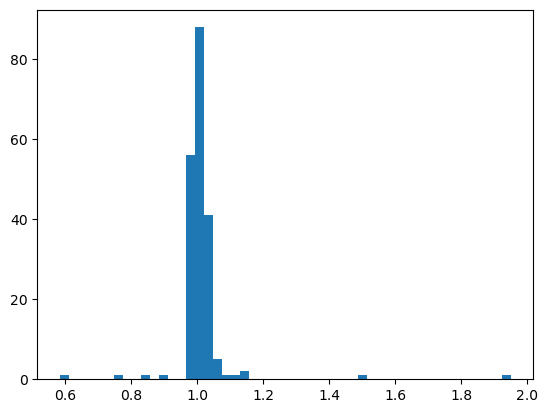

In [66]:
y_pred = y_pca.inverse_transform(y_pca_pred)

relative_L2 = np.linalg.norm(y_pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1)

print(f'median relative L2: {np.median(relative_L2)}')
print(f'mean relative L2: {np.mean(relative_L2)}')

plt.figure()
plt.hist(relative_L2, bins = 50)
plt.show()

In [ ]:
pred.shape

(128, 200)

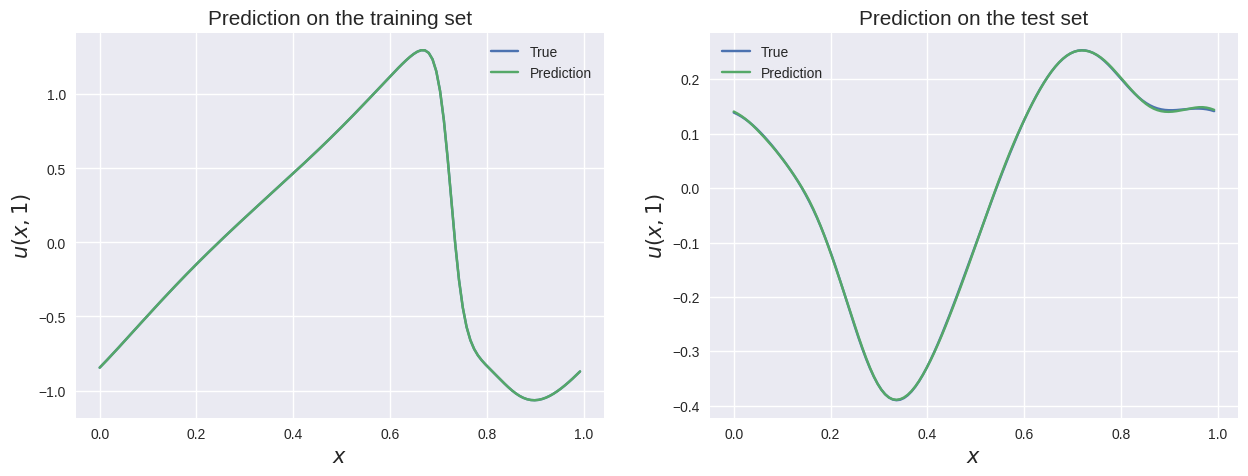

In [ ]:
idx = 15
i = 0

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,5))
ax1.plot(grid, y_train[idx], label = "True")
ax1.plot(grid, pred_train[idx], label = "Prediction")
ax1.set_xlabel(r'$x$', size= 15)
ax1.set_ylabel(r'$u(x,1)$', size= 15)
ax1.set_title("Prediction on the training set", size = 15)
ax1.legend()

ax2.plot(grid, y_test[idx],  label = "True")
ax2.plot(grid, pred[idx],  label = "Prediction")
ax2.set_xlabel(r'$x$', size= 15)
ax2.set_ylabel(r'$u(x, 1)$', size= 15)
ax2.set_title("Prediction on the test set", size = 15)
ax2.legend()

In [ ]:
np.random.default_rng()

Generator(PCG64) at 0x7F2837E02580

# Linear regression

In [ ]:
def train_test(x_train, x_test, y_train, y_test, n_pca, model):
    # Compute the PCA decoposition
    pca = PCA(n_components=n_pca)
    x_train_pca = pca.fit_transform(x_train)
    x_test_pca = pca.transform(x_test)

    
    model.fit(x_train_pca, y_train)
    pred= model.predict(x_test_pca)
    pred_train = model.predict(x_train_pca)

    #e = compute_error_dataset(y_test, pred, knots, k)

    return pred, model, pred_train

In [ ]:
model = LinearRegression()

In [ ]:
pca_modes = np.arange(1, 20)

pca_error = []
for n_pca in pca_modes:
    error = []
    for i in range(5):
        x_train = x[i*169: i*169 + 1000]
        y_train = y[i*169: i*169 + 1000]
        #print(x_train.shape)
        pred, GP, pred_train = train_test(x_train, x_test, y_train, y_test, n_pca, model)
        e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))
        error.append(e)
    pca_error.append(np.mean(error))

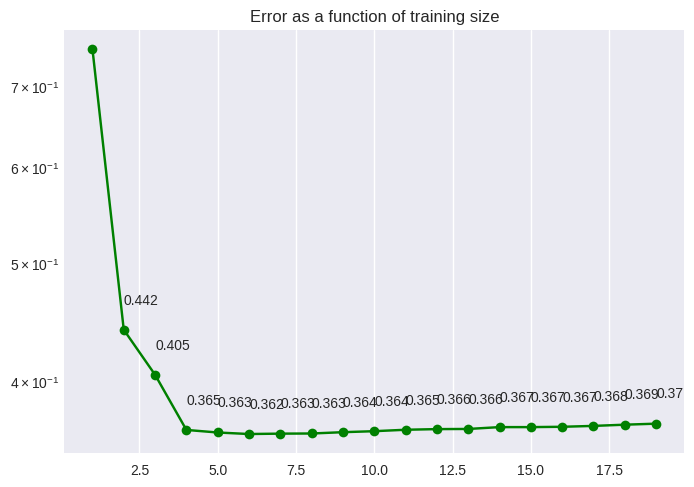

In [ ]:
plt.figure()
plt.plot(pca_modes,pca_error, '-go')
plt.yscale('log')
plt.title("Error as a function of training size")

for s, d in zip(pca_error, pca_modes):
    plt.annotate(np.round(s, 3), xy = (d ,s + s/20 ))
    
    
plt.show()

In [ ]:
np.min(pca_error), np.argmin(pca_error)

(0.3623501111918679, 5)

In [ ]:
i = 0
x_train = x[i*169: i*169 + 1000]
y_train = y[i*169: i*169 + 1000]

n_pca = 5
pred, model, pred_train = train_test(x_train, x_test, y_train, y_test, n_pca, model)
#pred_train = model.predict(x_train)

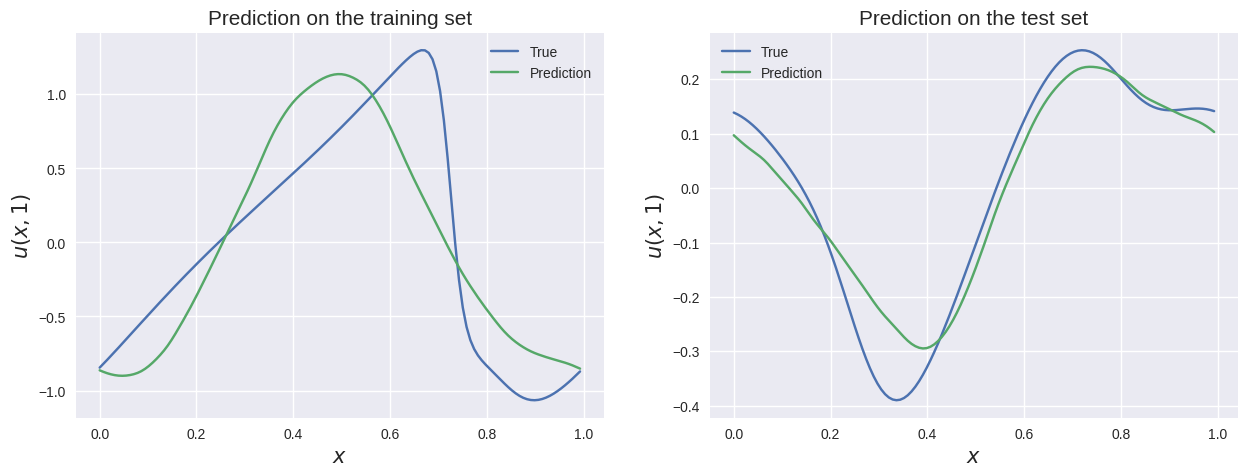

In [ ]:
idx = 15
i = 0

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,5))
ax1.plot(grid, y_train[idx], label = "True")
ax1.plot(grid, pred_train[idx], label = "Prediction")
ax1.set_xlabel(r'$x$', size= 15)
ax1.set_ylabel(r'$u(x,1)$', size= 15)
ax1.set_title("Prediction on the training set", size = 15)
ax1.legend()

ax2.plot(grid, y_test[idx],  label = "True")
ax2.plot(grid, pred[idx],  label = "Prediction")
ax2.set_xlabel(r'$x$', size= 15)
ax2.set_ylabel(r'$u(x, 1)$', size= 15)
ax2.set_title("Prediction on the test set", size = 15)
ax2.legend()

# Polynomial regression

In [ ]:
poly = PolynomialFeatures(2)

x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.fit_transform(x_test)

model = LinearRegression()

In [ ]:
pca_modes = np.arange(1, 20)

pca_error = []
for n_pca in pca_modes:
    error = []
    for i in range(5):
        x_train = x[i*169: i*169 + 1000]
        y_train = y[i*169: i*169 + 1000]
        x_train_poly = poly.fit_transform(x_train)
        x_test_poly = poly.fit_transform(x_test)
        #print(x_train.shape)
        pred, GP, pred_train = train_test(x_train_poly, x_test_poly, y_train, y_test, n_pca, model)
        e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))
        error.append(e)
    pca_error.append(np.mean(error))

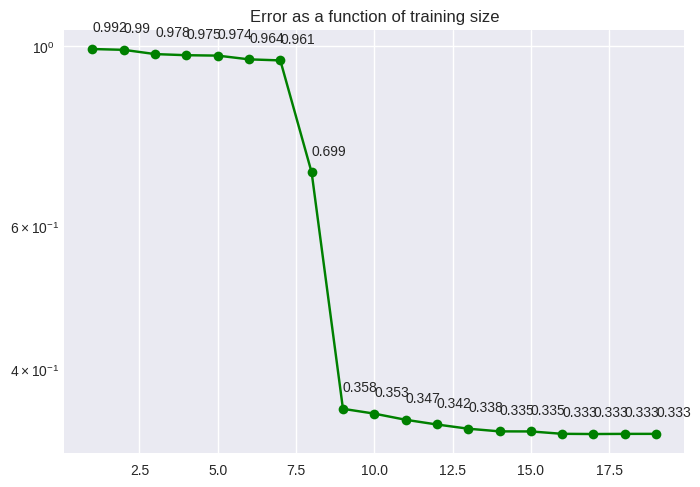

In [ ]:
plt.figure()
plt.plot(pca_modes,pca_error, '-go')
plt.yscale('log')
plt.title("Error as a function of training size")

for s, d in zip(pca_error, pca_modes):
    plt.annotate(np.round(s, 3), xy = (d ,s + s/20 ))
    
    
plt.show()

In [ ]:
np.min(pca_error), np.argmin(pca_error)

(0.332854107418273, 16)

In [ ]:
i = 0
x_train = x[i*169: i*169 + 1000]
y_train = y[i*169: i*169 + 1000]

n_pca = 17
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.fit_transform(x_test)

pred, model, pred_train = train_test(x_train, x_test, y_train, y_test, n_pca, model)
#pred_train = model.predict(x_train)

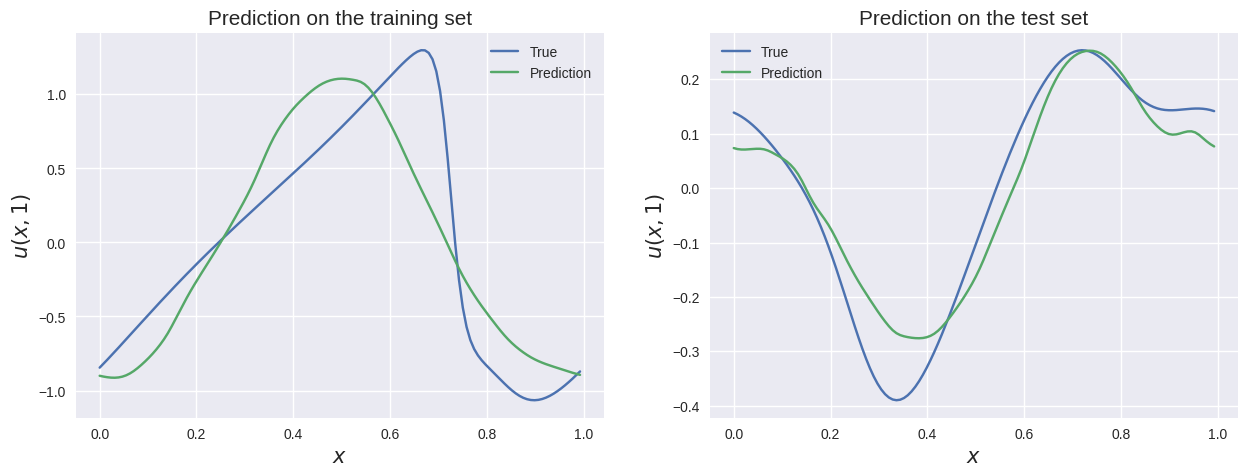

In [ ]:
idx = 15
i = 0

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,5))
ax1.plot(grid, y_train[idx], label = "True")
ax1.plot(grid, pred_train[idx], label = "Prediction")
ax1.set_xlabel(r'$x$', size= 15)
ax1.set_ylabel(r'$u(x,1)$', size= 15)
ax1.set_title("Prediction on the training set", size = 15)
ax1.legend()

ax2.plot(grid, y_test[idx],  label = "True")
ax2.plot(grid, pred[idx],  label = "Prediction")
ax2.set_xlabel(r'$x$', size= 15)
ax2.set_ylabel(r'$u(x, 1)$', size= 15)
ax2.set_title("Prediction on the test set", size = 15)
ax2.legend()

# Polynomial regression deg 3

In [ ]:
poly = PolynomialFeatures(3)

x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.fit_transform(x_test)

model = LinearRegression()

In [ ]:
pca_modes = np.arange(5, 20)

pca_error = []
for n_pca in pca_modes:
    print(n_pca)
    error = []
    for i in range(5):
        x_train = x[i*169: i*169 + 1000]
        y_train = y[i*169: i*169 + 1000]
        x_train_poly = poly.fit_transform(x_train)
        x_test_poly = poly.fit_transform(x_test)
        #print(x_train.shape)
        pred, GP, pred_train = train_test(x_train_poly, x_test_poly, y_train, y_test, n_pca, model)
        e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))
        error.append(e)
    pca_error.append(np.mean(error))

5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


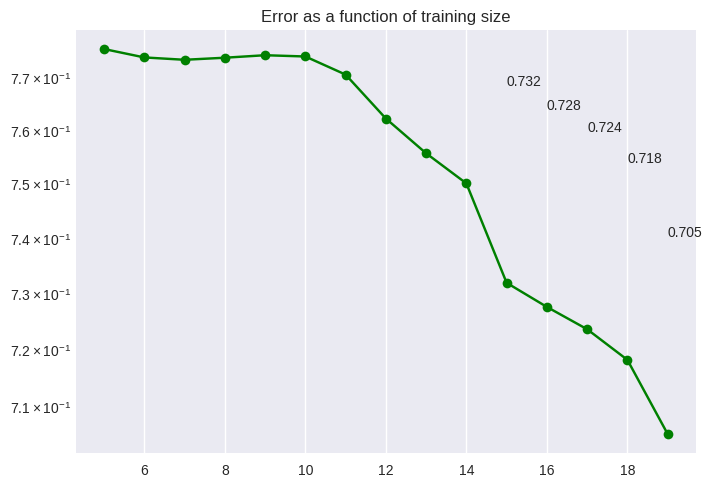

In [ ]:
plt.figure()
plt.plot(pca_modes,pca_error, '-go')
plt.yscale('log')
plt.title("Error as a function of training size")

for s, d in zip(pca_error, pca_modes):
    plt.annotate(np.round(s, 3), xy = (d ,s + s/20 ))
    
    
plt.show()

In [ ]:
np.min(pca_error), np.argmin(pca_error)

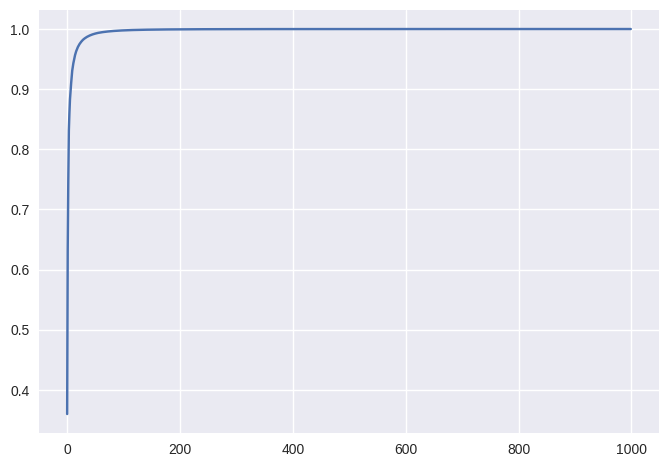

13

In [ ]:


i = 0
x_train = x[i*169: i*169 + 1000]
y_train = y[i*169: i*169 + 1000]

x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.fit_transform(x_test)


pca = PCA(n_components=1000)
x_train_pca = pca.fit_transform(x_train_poly)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()
#print(np.cumsum(pca.explained_variance_ratio_))

np.where(np.cumsum(pca.explained_variance_ratio_) > 0.95)[0][0]

In [ ]:
n_pca = 13
print(n_pca)
error = []
for i in range(5):
        x_train = x[i*169: i*169 + 1000]
        y_train = y[i*169: i*169 + 1000]
        x_train_poly = poly.fit_transform(x_train)
        x_test_poly = poly.fit_transform(x_test)
        #print(x_train.shape)
        pred, GP, pred_train = train_test(x_train_poly, x_test_poly, y_train, y_test, n_pca, model)
        e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))
        error.append(e)
print(np.mean(error))

13
0.7556950345566795


In [ ]:
np.where(np.cumsum(pca.explained_variance_ratio_) > 0.99)[0][0]

42

In [ ]:
n_pca = 42
print(n_pca)
error = []
for i in range(5):
        x_train = x[i*169: i*169 + 1000]
        y_train = y[i*169: i*169 + 1000]
        x_train_poly = poly.fit_transform(x_train)
        x_test_poly = poly.fit_transform(x_test)
        #print(x_train.shape)
        pred, GP, pred_train = train_test(x_train_poly, x_test_poly, y_train, y_test, n_pca, model)
        e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))
        error.append(e)
print(np.mean(error))

42
0.5990256818282329


In [ ]:
np.where(np.cumsum(pca.explained_variance_ratio_) > 0.999)[0][0]

149

In [ ]:
n_pca = 149
print(n_pca)
error = []
for i in range(5):
        x_train = x[i*169: i*169 + 1000]
        y_train = y[i*169: i*169 + 1000]
        x_train_poly = poly.fit_transform(x_train)
        x_test_poly = poly.fit_transform(x_test)
        #print(x_train.shape)
        pred, GP, pred_train = train_test(x_train_poly, x_test_poly, y_train, y_test, n_pca, model)
        e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))
        error.append(e)
print(np.mean(error))

149
0.24391256920185636


In [ ]:
def train_test_no_pca(x_train, x_test, y_train, y_test, model):

    
    model.fit(x_train, y_train)
    pred= model.predict(x_test)
    pred_train = model.predict(x_train)

    #e = compute_error_dataset(y_test, pred, knots, k)

    return pred, model, pred_train

In [ ]:
error = []
for i in range(5):
        x_train = x[i*169: i*169 + 1000]
        y_train = y[i*169: i*169 + 1000]
        x_train_poly = poly.fit_transform(x_train)
        x_test_poly = poly.fit_transform(x_test)
        #print(x_train.shape)
        pred, GP, pred_train = train_test_no_pca(x_train_poly, x_test_poly, y_train, y_test, model)
        e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))
        error.append(e)
print(np.mean(error))

0.2814261882757557


In [ ]:
i = 0
x_train = x[i*169: i*169 + 1000]
y_train = y[i*169: i*169 + 1000]

n_pca = 149
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.fit_transform(x_test)

pred, model, pred_train = train_test(x_train_poly, x_test_poly, y_train, y_test, n_pca, model)
#pred_train = model.predict(x_train)

In [ ]:
e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))

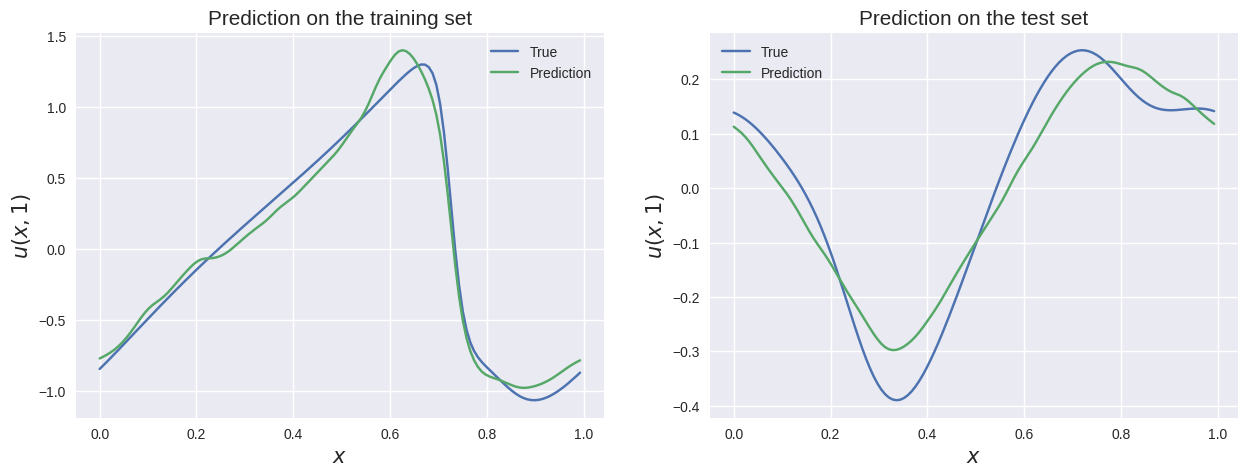

In [ ]:
idx = 15
i = 0

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,5))
ax1.plot(grid, y_train[idx], label = "True")
ax1.plot(grid, pred_train[idx], label = "Prediction")
ax1.set_xlabel(r'$x$', size= 15)
ax1.set_ylabel(r'$u(x,1)$', size= 15)
ax1.set_title("Prediction on the training set", size = 15)
ax1.legend()

ax2.plot(grid, y_test[idx],  label = "True")
ax2.plot(grid, pred[idx],  label = "Prediction")
ax2.set_xlabel(r'$x$', size= 15)
ax2.set_ylabel(r'$u(x, 1)$', size= 15)
ax2.set_title("Prediction on the test set", size = 15)
ax2.legend()